In [1]:
from simMat import *

dataPath = '../Data/'
simMat_yr = np.load(dataPath + 'history_simMat.npy')
            
min_yr = 1771
print(simMat_yr.shape)

(247, 103, 103)


# Meaning of 0s and nans

If element exists to this year, but similarity == 0, plot 0.

If element doesn't exist, then similarity == 0, but plot nan.

---

### Sample plots based on similarity matrices.

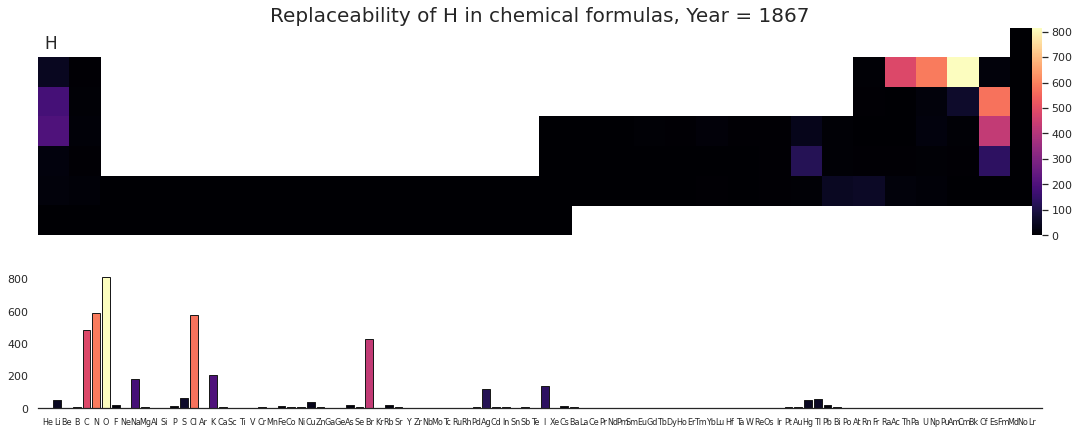

In [2]:
plot_SimPTBar(simMat_yr,1867,'H',min_yr,save=dataPath+"Results/replace_H.png")

# 1D Periodic Table

Based on the work of [Glawe et.al.](https://iopscience.iop.org/article/10.1088/1367-2630/18/9/093011), we define a new matrix P, a symmetrized and normalized version of the matrices we've been working with. Here, $S_{AB}$ are calculated as the net number of similarity relationships (R,n) joining the elements A and B.

Matrix elements $P_{AB}$ are defined as follows:

$$
P_{AB} = \sqrt{\frac{S_{AB}^2}{(\sum_{A'}{S_{A'B}})(\sum_{B'}{S_{AB'}})}}
$$

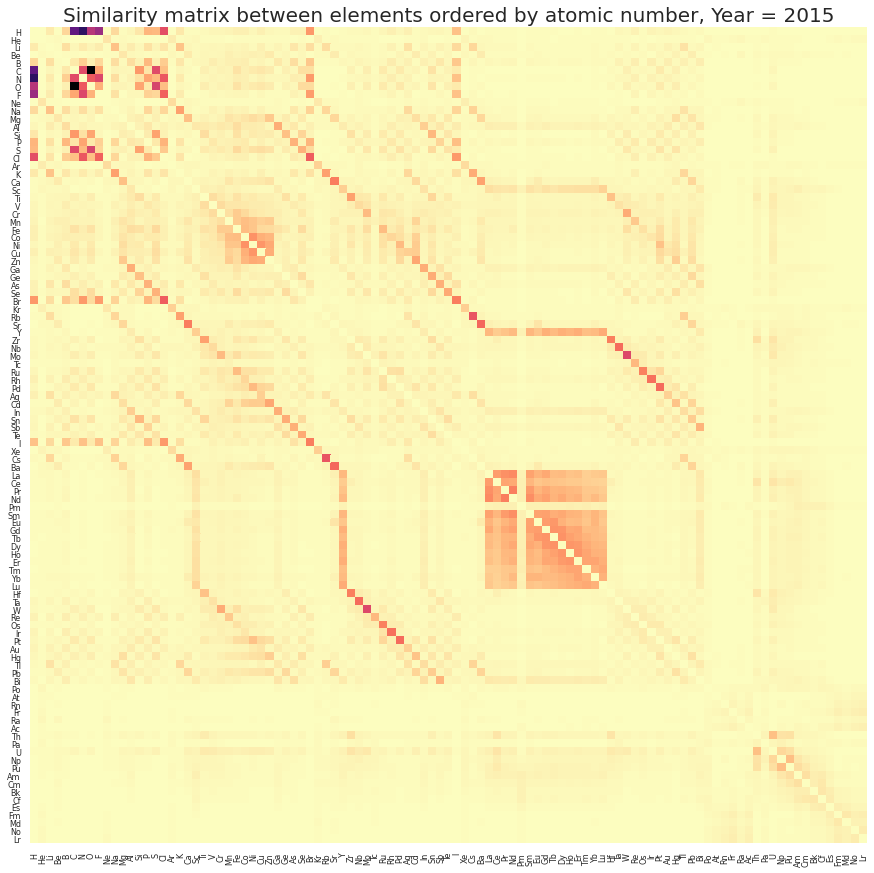

In [3]:
_ = plot_simMat_yr(simMat_yr,2015,min_yr=min_yr,raw=False,scale=15,save=dataPath+"Results/simMat2015.png")

### Here we get the same overall patterns as the reference, only that somewhat obfuscated by the similarity between H and O, C, N, not obtained there. With this, let us now try to reproduce their results.

For various reasons, the present work represents a huge step forward relative to the reference:
- As we include data from all existing compounds in Reaxys, not limited to inorganic or even solids, we use far more data for our analysis, and thus provide a much less biased picture of the results.
- We are able to perform historical analyses. In that sense, we could try to answer the question about how different formulations of 1D periodic tables evolve with an evolving chemical space.

---

The cost function we'll be using here is defined below.

$$
F = -\sum_{A,B \neq A} \frac{P_{AB}}{|i_A - i_B|}
$$

Which takes into account the distances between all pairs of elements in the given ordering $i$, and weights each contribution with the elements $P_{AB}$.

### For what follows: If we're doing historical analyses, some elements will be missing. If so, fill nans with zeros on matrix P, for code reusability (so P and orderings have all the same dimensions regardless of year).

### Some tests:

- Some reference costs:
    - Atomic Number ordering
    - Random orderings
    - Pettifor original scale
    - Glawe's GA scale
    
- Check how many possible orderings there are for 103 elements in our dataset.

In [2]:
from genetic1D import *

# Calculate P for calculating cost function
year=2015
S = simMat_yr[year - min_yr].copy()
P = symmetrize(S)

# Set a reference ordering: atomic number
orderAO = np.arange(P.shape[0])

print(f"Cost using AN order = {cost(P, orderAO):.5f}")

# 2. Check how Pettifor's scale does on these data.
pettif = ['He','Ne','Ar','Kr','Xe','Rn','Fr','Cs','Rb','K','Na','Li','Ra','Ba','Sr','Ca','Yb','Eu','Y',
          'Sc','Lu','Tm','Er','Ho','Dy','Tb','Gd','Sm','Pm','Nd','Pr','Ce','La','Lr','No','Md','Fm','Es',
          'Cf','Bk','Cm','Am','Pu','Np','U','Pa','Th','Ac','Zr','Hf','Ti','Nb','Ta','V','Mo','W','Cr',
          'Tc','Re','Mn','Fe','Os','Ru','Co','Ir','Rh','Ni','Pt','Pd','Au','Ag','Cu','Mg','Hg','Cd','Zn',
          'Be','Tl','In','Al','Ga','Pb','Sn','Ge','Si','B','Bi','Sb','As','P','Po','Te','Se','S','C','At',
          'I','Br','Cl','N','O','F','H']

# List the position of each element in Pettifor scale
order_pett = np.array([pettif.index(e) for e in TP.keys()])
# e.g. H: 102, He: 0, Li: 11, etc
print(f"Cost Pettifor = {cost(P, order_pett):.5f}")

# See how their GA solution works

GA_ref = ['He','Ne','Ar','At','Rn','Fr','Es','Fm','Md','No','Lr','Kr','Xe','Pm','Cs','Rb','K','Na',
          'Li','Ra','Ba','Sr','Ca','Eu','Yb','Lu','Tm','Y','Er','Ho','Dy','Tb','Gd','Sm','Nd','Pr',
          'Ce','La','Ac','Am','Cm','Bk','Cf','Pu','Np','U','Th','Pa','Sc','Zr','Hf','Ti','Nb','Ta',
          'V','Cr','Mo','W','Re','Tc','Os','Ru','Ir','Rh','Pt','Pd','Au','Ag','Cu','Ni','Co','Fe',
          'Mn','Mg','Zn','Cd','Hg','Be','Al','Ga','In','Tl','Pb','Sn','Ge','Si','B','C','N','P','As',
          'Sb','Bi','Po','Te','Se','S','O','I','Br','Cl','F','H']

# List the position of each element in Pettifor scale
order_GA = np.array([GA_ref.index(e) for e in TP.keys()])
# e.g. H: 102, He: 0, Li: 11, etc
print(f"Cost GA Glawe = {cost(P, order_GA):.5f}\n")


# Performance of random configurations
rand_ord_cost = [cost(P, np.random.permutation(orderAO)) for i in range(5000)]
print(pd.Series(rand_ord_cost).describe())

Cost using AN order = -8.66470
Cost Pettifor = -12.56132
Cost GA Glawe = -12.63149

count    5000.000000
mean       -4.355471
std         0.233059
min        -5.418755
25%        -4.492089
50%        -4.333678
75%        -4.192757
max        -3.797418
dtype: float64


Here, we -sort of- reproduce the article's results. We see that random orderings have F values typically between $-4$ and $-5$, while using AN ordering improves this value down to $-8.66$. Pettifor does much better, and the GA solution does perform better than the original Pettifor scale, although is not as dramatic a result as reported in ref.

--- 

In [3]:
# Check how many possible orderings there are for 103 elements in our dataset. 
# This is clearly equal to N!
def factorial(N):
    preexp = np.sum(np.log(np.arange(1,N+1)))
    return np.exp(preexp)
factorial(103)

9.902900716486875e+163

Way too much for even aspiring to the evaluation of all possible configurations.

## Now finally: Let's implement a genetic algorithm for optimization of a Pettifor scale with our own data. :)

Ultimately, what we need to do is find an optimal permutation of the numbers in the range from 0 to $N$ ($N=103$ in 2015). 

The algorithm (as implemented in `genetic1D.py`) works as follows:

- An `Individual` class is created. And instance of this is a particular ordering with derived properties such as cost, and functions useful for optimization, such as crossover and mutate.

- A `Population` class is created. This generates a collection of `Individual` instances, and allows to optimize from this gene pool.

Ultimately, the code for an optimization looks as follows:
<br>

```python
T , popSize, NGens, mutRate = 0.4,1000, 500, 0.2
breed = Population(popSize,103).evolve(NGens,T=T,mutRate=mutRate)
```

Parameters T, popSize, NGens, mutRate must be tuned.

- T is a temperature parameter of a Boltzmann's distribution. It controls how much attention is placed on best-performing individuals each generation.

In [8]:
T , popSize = 0.4,5000
b = Population(popSize,103,P=P).evolve(500,mutRate=0.2,T=T)

** Iter No. 0, Mean = -4.438, Min = -5.700, P0
** Iter No. 50, Mean = -10.144, Min = -11.823, P0
** Iter No. 100, Mean = -11.399, Min = -12.836, P0
** Iter No. 150, Mean = -11.963, Min = -13.239, P0
** Iter No. 200, Mean = -12.155, Min = -13.401, P0
** Iter No. 250, Mean = -12.320, Min = -13.429, P0
** Iter No. 300, Mean = -12.312, Min = -13.451, P0
** Iter No. 350, Mean = -12.317, Min = -13.484, P0
** Iter No. 400, Mean = -12.348, Min = -13.497, P0
** Iter No. 450, Mean = -12.376, Min = -13.535, P0


### The population above was saved under `./Genetic1D/breed5k4.breed`

In [4]:
# Load a few previous results for 2015
populs5k = []
for i in range(5):
    filehandler = open(f'./Genetic1D/breed5k{i}.breed', 'rb') 
    populs5k.append(pickle.load(filehandler))
    
b = populs5k[-1]
populs5k = populs5k[:-1]

-13.53670949074235


array(['At', 'Rn', 'Pd', 'Pt', 'Fe', 'Ru', 'Os', 'Ir', 'Rh', 'Po', 'Tc',
       'Re', 'Au', 'Ag', 'Li', 'Pa', 'Bi', 'Sb', 'As', 'B', 'P', 'I',
       'Br', 'Cl', 'F', 'N', 'H', 'O', 'C', 'S', 'Si', 'Cu', 'Ni', 'Co',
       'Zn', 'Mn', 'Ti', 'Zr', 'Hf', 'Cd', 'Hg', 'Sn', 'Ge', 'Se', 'Te',
       'Es', 'Cf', 'Bk', 'V', 'Cr', 'W', 'Mo', 'U', 'Th', 'Np', 'Pu',
       'Am', 'Cm', 'Gd', 'Tb', 'Eu', 'Nd', 'Pr', 'Ho', 'Dy', 'Sm', 'La',
       'Y', 'Yb', 'Er', 'Tm', 'Lu', 'Ce', 'Sc', 'Pm', 'Be', 'Mg', 'Ca',
       'Ba', 'Sr', 'Pb', 'Nb', 'Ta', 'Tl', 'Rb', 'Cs', 'K', 'Na', 'Xe',
       'Kr', 'Ar', 'Ga', 'In', 'Al', 'Ne', 'He', 'Ra', 'Fr', 'No', 'Fm',
       'Lr', 'Md', 'Ac'], dtype='<U2')

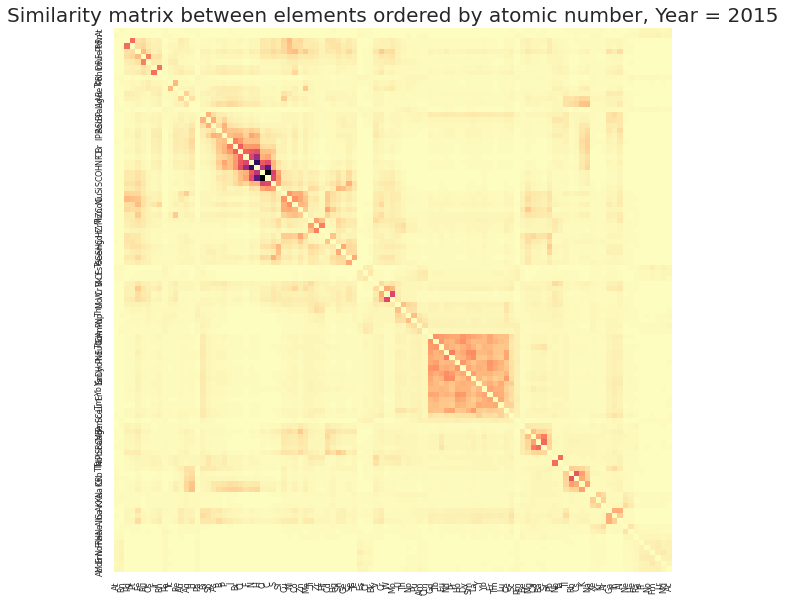

In [5]:
plot_simMat_yr(simMat_yr,2015,min_yr=min_yr,raw=False,scale=10,ordering=b.bestIndiv.gen)
print(b.bestCost)
np.array(genToElem(b.bestIndiv.gen))

## The results so far are superior to those of Glawe (with our dataset).

### Let's now try to compare different candidate configurations. As opposed to the reference, where the authors visually inspected the orderings, here we'll use more formal quantities that allow to rate similarities between scales, and don't depend on fixed extremes (ref. used Kr and H to be fixed as fixed extremes of the orderings).

The idea so far is to compare the content of N-grams. For instance, if an ordering $O_1$ has the ordered pair (Na,K) at position $N_1$, and ordering $O_2$ has the ordered pair (K,Na) at position $N_2$, $N_1 \neq N_2$, then both orderings have a strong sense of similarity between Na and K, regardless of localization within the particular ordering ($N_i$), or of the particular ordering of the given ordered pair. This should be reflected on our similarity measure between $O_1$ and $O_2$.

The pairs above are examples of 2-grams, but we could also take the same approach for 3-grams, and so on.

### For N-Grams with N>2, we may allow some flexibility:

### Example
Consider the orderings

<font size=5>
<br>

1. (<span style="background-color: #FFFF00">K, Li, Na</span>, <span style="background-color: #2ee730">He, Kr, Ar, Ne</span>, <span style="background-color: #2ee7c9">La, Lu, Ce, Pr</span>)
<br>

2. (<span style="background-color: #2ee7c9">Pr, Lu, Ce, La</span>, <span style="background-color: #FFFF00">Li , K, Na</span>, <span style="background-color: #2ee730">Ar, He, Ne, Kr</span>)

</font>

Here, we see that both orderings contain some important PT groups, however these groups `are not listed in the same order`, and the `inner ordering of each group varies`.

### If we consider 3-Grams, then a strict comparison would imply that both orderings are completely different! (no 3-Gram in $O_1$ is found in $O_2$).

### However, we can make a more flexible comparison, and let the 3-Grams become sets (3-Gram-Set, 3-GS). In that case, we'd be comparing sets which is more fair.

However, this is still too limited. In the example above, under the current approximation, we see that no 3-Gram-Set formed with green group is found in common between the two orderings, even though the green group is clearly identified in both of them.

### We further relax the definition by letting the similarity increase if 2 elements are found at the intersection of 2 given 3-GS. 

In this case, comparison of the green groups produces an increment of 2 to the similarity measure.

This approach can be understood as follows:

- Similarity increases by 1 if `the distance between a given pair of elements is found to be less than 2, in both orderings`. (If we use 3-GS)

In [6]:
def genToElem(gen):
    order = ['_' for i in range(103)]
    for i,idx in enumerate(gen):
        order[idx] = elemList_AO[i]
    return order

def getNGrams(seq,N):
    """Returns a list of NGrams (sets) in seq"""
    ngrams = []
    for i in range(len(seq)-N+1):
        ngrams.append(set(seq[i:i+N]))
    return ngrams

def compareNGrams(seq1,seq2,N):
    """Compare NGrams of seq1 and seq2
    Calculate number of NGrams of seq1 that are also in seq2, divided by number of NGrams in seq1
    """
    ng1 = getNGrams(seq1,N)
    ng2 = getNGrams(seq2,N)
    
    """An N-Gram from ng1 can be compared with more than one of ng2.
    Normalization constant is calculated by comparing a seq to itself"""
    Norm = {2:102,3:301,4:494,5:681}
    
    total = 0
    for i in ng1:
        for j in ng2:
            if len(i.intersection(j)) > 1: total += 1
    return total/Norm[N]

### Check if there's a correlation between NGram similarity and difference in cost

In [7]:
## Load sample populations of diverse costs
filehandler = open(f'./Genetic1D/test_populs.breed', 'rb') 
populats_test = pickle.load(filehandler)

## Compare all these individuals agains the best solution so far.

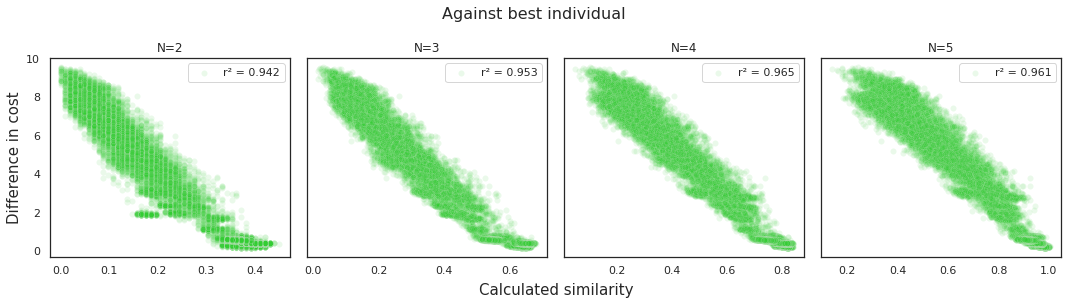

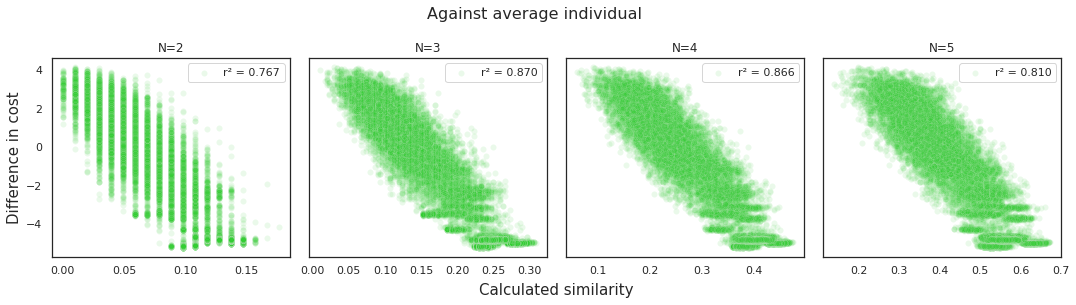

In [44]:
from scipy.stats import linregress

def NGSvsCost(ref_indiv,comparePops,title):
    costs, ni = [], {i:[] for i in range(2,6)}
    # Calculate for the sample populations produced above
    for i in comparePops:
        for j in range(len(i.costs)):
            s1 = genToElem(ref_indiv.gen)
            s2 = genToElem(i.indivs[j].gen)
            
            costs.append(-ref_indiv.cost + i.indivs[j].cost)
            for k in range(2,6):
                ni[k].append(compareNGrams(s1,s2,k))

    fig,ax = plt.subplots(1,4,figsize=(15,4),sharey=True,)
    fig.suptitle(title, fontsize=16)
    ax = ax.ravel()
    
    for i in range(2,6):
        ax[i-2].set_title(f"N={i}")
        r2 = linregress(ni[i],costs).rvalue**2
        sns.scatterplot(x=ni[i],y=costs,alpha=0.1,ax=ax[i-2],color='limegreen',label=f"r² = {r2:.3f}")
        ax[i-2].legend()
        
    ax[0].set_ylabel("Difference in cost",fontsize=15)
    fig.text(0.52,-0.02, 'Calculated similarity',ha='center',fontsize=15)
    
    plt.tight_layout()
    plt.savefig(f'../Data/Results/metric_{title.replace(" ","_")}',bbox_inches='tight',dpi=300)
        
NGSvsCost(b.bestIndiv,populats_test+populs5k,title='Against best individual')
NGSvsCost(populats_test[2].indivs[10],
          populats_test[:2]+populats_test[3:]+populs5k,
          title='Against average individual')

---

# Historical anlysis

Load `bestIndivs_yearly.gen`, a dict with optimized individuals for each year.

In [45]:
fh = open(f'./Genetic1D/bestIndivs_yearly.gen', 'rb') 
Indivs_yr = pickle.load(fh)

In [46]:
for i in range(20):
    print(cost(P,Indivs_yr[2016][i]))

-13.901718995744368
-13.356523513070174
-13.623716293194251
-13.59204558130384
-13.968781985447663
-13.308035986721356
-13.395150691373999
-13.37218346143003
-13.510042007774533
-13.779491013262144
-13.415332668381302
-13.828993051320202
-13.906388249667826
-13.407837040110785
-13.786858772218046
-14.09518923894537
-13.391123202624122
-13.688800478516926
-13.353288897800516
-13.551407557117146


In [5]:
## Here, we define a general similarity function between orderings

# First, precalc. normalization constants
normConsts_sim = {}

# These depend on: lenSeq and N
for lenSeq in range(10,105):
    for N in range(3,10):
        ng = getNGrams(genToElem(Indivs_yr[1820][0])[:lenSeq],N)
        Norm = 0
        for i in ng:
            for j in ng:
                if len(i.intersection(j)) >1:
                    Norm += 1 
        normConsts_sim[f"{N}:{lenSeq}"] = Norm

# Define similarity function
def compareNGrams_asym(seq1,seq2,N,lenSeq1):
    """Compare NGrams of seq1 and seq2
    Calculate number of NGrams of seq1 that are also in seq2, divided by number of NGrams in seq1
        As some elements are lacking for some years, 
        compare only the patterns formed by existing elements (lenSeq1 first elems)
    """
    ng1 = getNGrams(seq1[:lenSeq1],N)
    ng2 = getNGrams(seq2,N)

    total = 0
    for i in ng1:
        for j in ng2:
            if len(i.intersection(j)) > 1:
                total += 1
    return total

# And plot function
def plotHistory(matrix,sz=15,pad=4):
    fig,axi = plt.subplots(figsize=(sz+pad,sz))
    sns.heatmap(matrix,ax=axi)

    labels = [i for j,i in enumerate(Indivs_yr.keys()) if j%2==0]
    locs = (np.array(labels) - 1800)/2  + 0.5
    axi.set_xticks(locs)
    axi.set_yticks(locs)
    axi.set_xticklabels(labels,rotation=90)
    axi.set_yticklabels(labels,rotation=0)
    axi.invert_yaxis()
    
    
# Make a copy of Indivs_yr, that contains element sequences.
Indivs_yr_elemSeq = {}
for yr in Indivs_yr.keys():
    Indivs_yr_elemSeq[yr] = []
    for i,seq in enumerate(Indivs_yr[yr]):
        Indivs_yr_elemSeq[yr].append(genToElem(seq))
        
# Get best individuals of each year
bestIndivs_yr = {}
for yr in Indivs_yr.keys():
    P = simMat_yr[yr-min_yr]
    S = symmetrize(P)
    costs = [cost(P,order) for order in Indivs_yr[yr]]
    bestIndivs_yr[yr] = Indivs_yr_elemSeq[yr][np.argmin(costs)]
    
        
# Function to calculate all following matrices, in general
def compareSimYearly_best(symm=True,sz=15,pad=4,ngSize=3):
    N = len(Indivs_yr.keys())
    mat = np.zeros((N,N))

    elem_count = (simMat_yr.sum(axis=1)>0).sum(axis=1)
    for i,yr0 in enumerate(Indivs_yr.keys()):
        for j,yr1 in enumerate(Indivs_yr.keys()):
            if yr0<yr1:  # Calc only half the matrix
                s0, s1 = bestIndivs_yr[yr0], bestIndivs_yr[yr1]
                if symm: Nelemsyr0 = 103
                else:    Nelemsyr0 = elem_count[yr0-min_yr]
                mat[i,j] = compareNGrams_asym(s0,s1,ngSize,Nelemsyr0)
    mat += mat.T

    # Build normalization matrix
    if symm: NormMat = [normConsts_sim[f"{ngSize}:{103}"] for i in Indivs_yr.keys()]
    else:    NormMat = [normConsts_sim[f"{ngSize}:{elem_count[i-min_yr]}"] for i in Indivs_yr.keys()]
    NormMat = np.repeat(np.array(NormMat).reshape(-1,1),len(NormMat),axis=1)
    # Normalize and make diagonal == nan
    with np.errstate(divide='ignore',invalid='ignore'):
        mat /= NormMat*(np.eye(mat.shape[0])!=1)
    
    plotHistory(mat,sz,pad)
    return mat

from itertools import product
def compareSimYearly_all(symm=True,sz=15,pad=4,ngSize=3):
    N = len(Indivs_yr.keys())
    mat = np.zeros((N,N))

    elem_count = (simMat_yr.sum(axis=1)>0).sum(axis=1)
    for i,yr0 in enumerate(Indivs_yr.keys()):
        for j,yr1 in enumerate(Indivs_yr.keys()):
            if yr0<=yr1:  # Calc only half the matrix
                pairs = product(Indivs_yr_elemSeq[yr0],Indivs_yr_elemSeq[yr1])
                if symm: Nelemsyr0 = elem_count[-1]
                else:    Nelemsyr0 = elem_count[yr0-min_yr]
                mat[i,j] = np.mean([compareNGrams_asym(s0,s1,ngSize,Nelemsyr0) for s0,s1 in pairs]) 
                
    mat += mat.T
    # Correct diagonal 
    mat[np.diag_indices(N)] /= 2  #(divide by 2)
    mat[np.diag_indices(N)] -= 1/len(Indivs_yr[1800])  #remove self-comparisons (1/number indivs per year)  

    # Build normalization matrix
    if symm: NormMat = [normConsts_sim[f"{ngSize}:{103}"] for i in Indivs_yr.keys()]
    else:    NormMat = [normConsts_sim[f"{ngSize}:{elem_count[i-min_yr]}"] for i in Indivs_yr.keys()]
    NormMat = np.repeat(np.array(NormMat).reshape(-1,1),len(NormMat),axis=1)
    # Normalize
    mat /= NormMat

    plotHistory(mat,sz,pad)
    return mat

### 1. Use best individual of each year. Calculate symmetric similarities (equal normalization)

CPU times: user 14.2 s, sys: 75.1 ms, total: 14.2 s
Wall time: 14.2 s


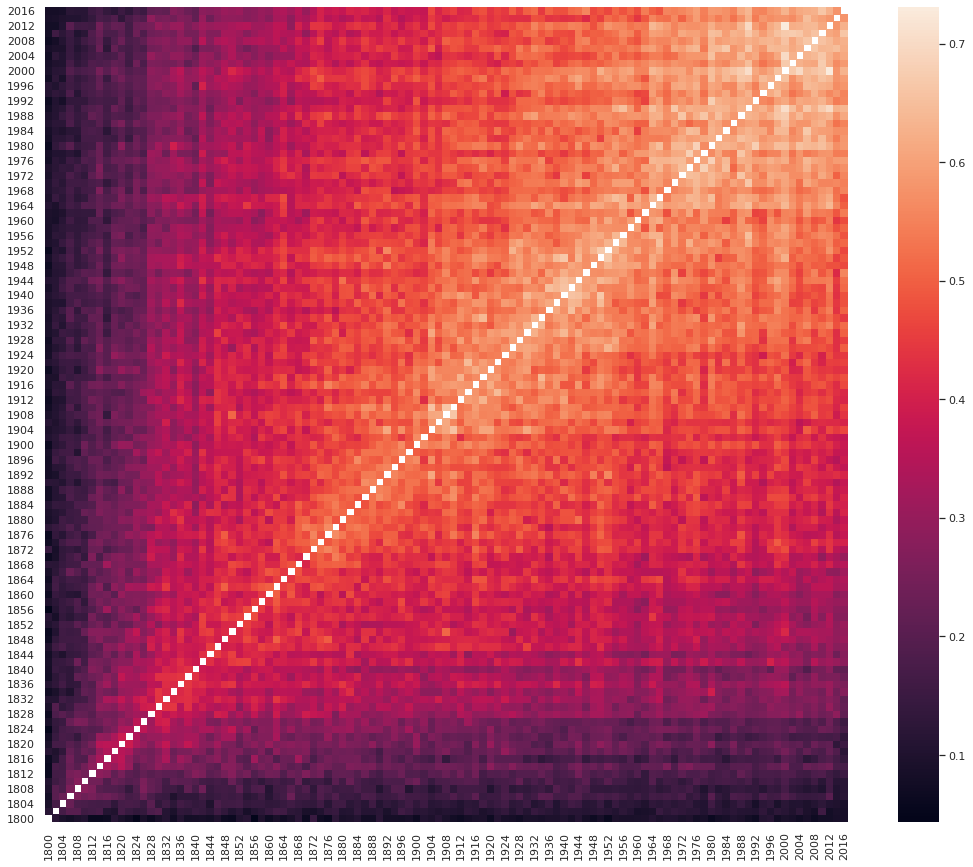

In [12]:
%%time
sim_best_symm = compareSimYearly_best(symm=True,sz=15,pad=3,ngSize=3)

### 2. Use an asymmetric version of similarity measure, accounting for different number of elements known each year.

CPU times: user 8.93 s, sys: 35.6 ms, total: 8.97 s
Wall time: 8.97 s


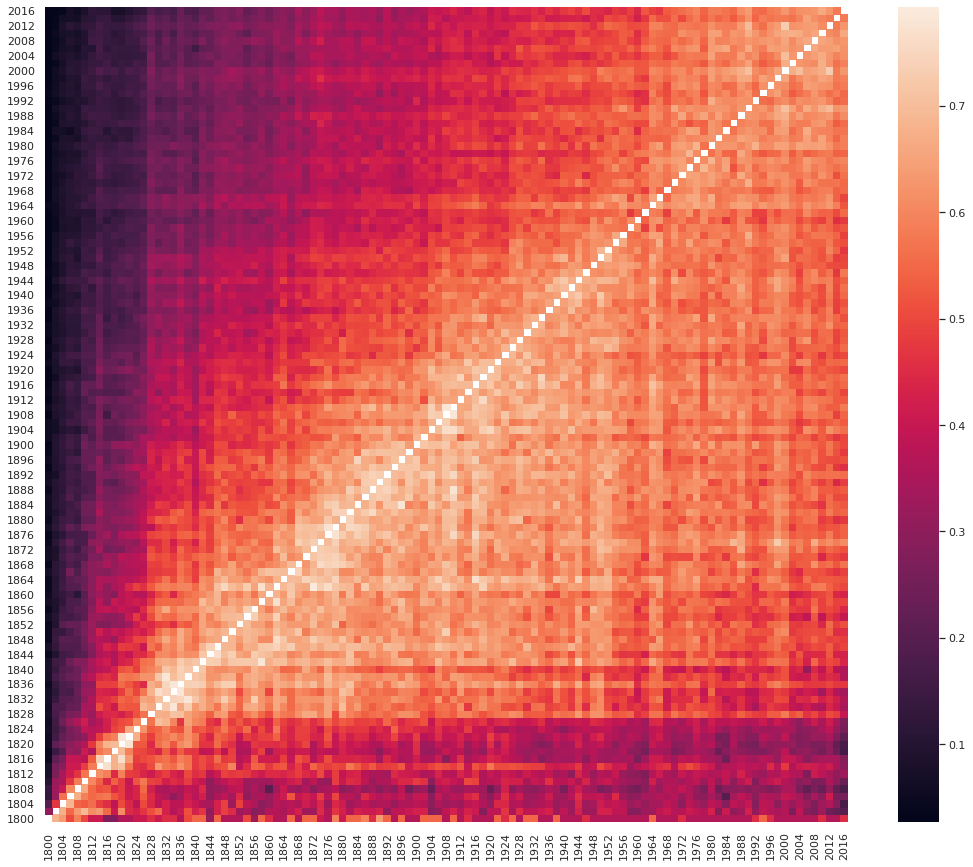

In [13]:
%%time
sim_best_asymm = compareSimYearly_best(symm=False,sz=15,pad=3,ngSize=3)

### Lower triangle: Compare past PS against future PSs. That is, which proportion of the relations found in e.g. 1828 are also found in later years? 

### Upper triangle: Compare future against past years. What proportion of the relations found in 1960 are also found in 1830? This should be very low, as most of the elements in 1830 are placed randomly (no data for them).

Our results so far show that the relations found since 1828 have been reinforced enough to still be found nearly 200 years later.

### 3. Use all individuals from each year (for less biased analysis). Calc sim between all pairs of indivs of each pair of years, and report mean of that similarity for that entry.

CPU times: user 1h 28min 43s, sys: 1.22 s, total: 1h 28min 44s
Wall time: 1h 28min 45s


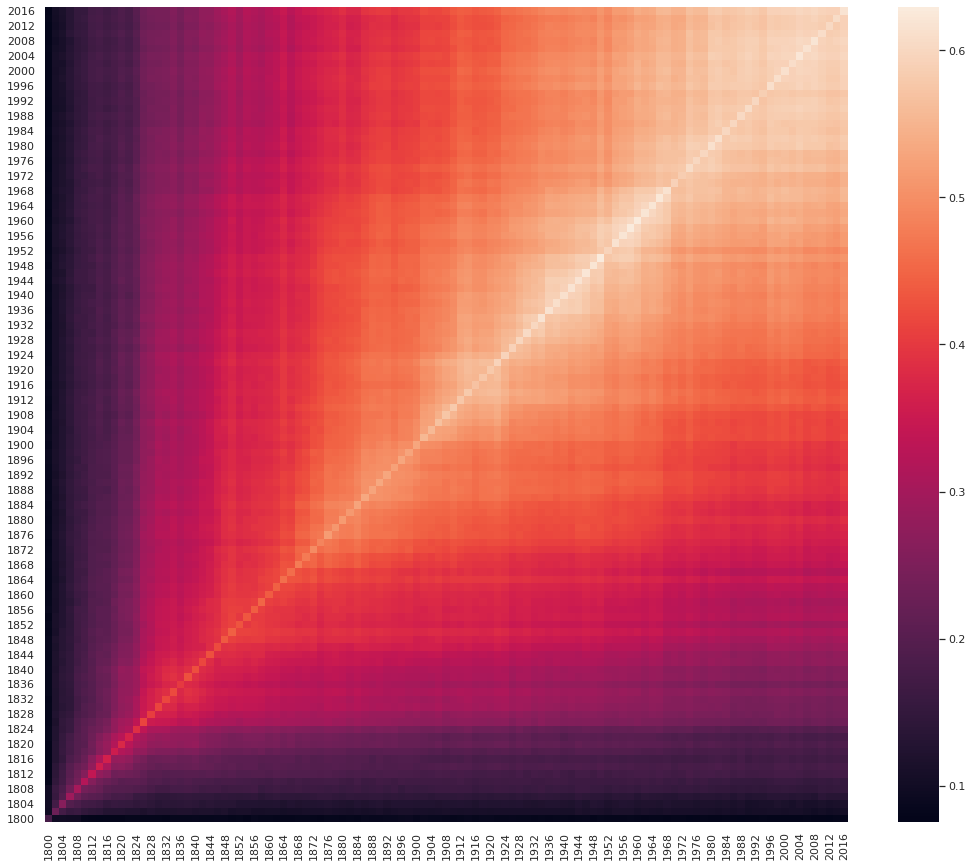

In [16]:
%%time
sim_all_symm = compareSimYearly_all(symm=True,sz=15,pad=3,ngSize=3)

### 4. Do asymmetric version of 3.

CPU times: user 54min 33s, sys: 708 ms, total: 54min 33s
Wall time: 54min 34s


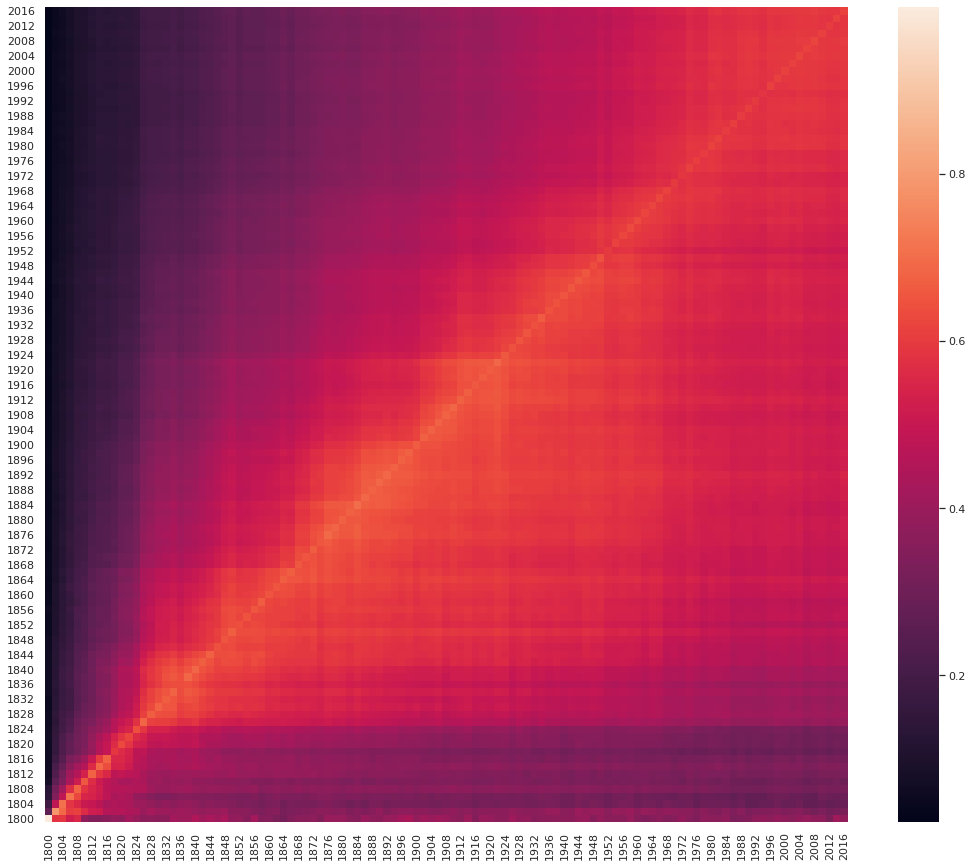

In [17]:
%%time
sim_all_asymm = compareSimYearly_all(symm=False,sz=15,pad=3,ngSize=3)

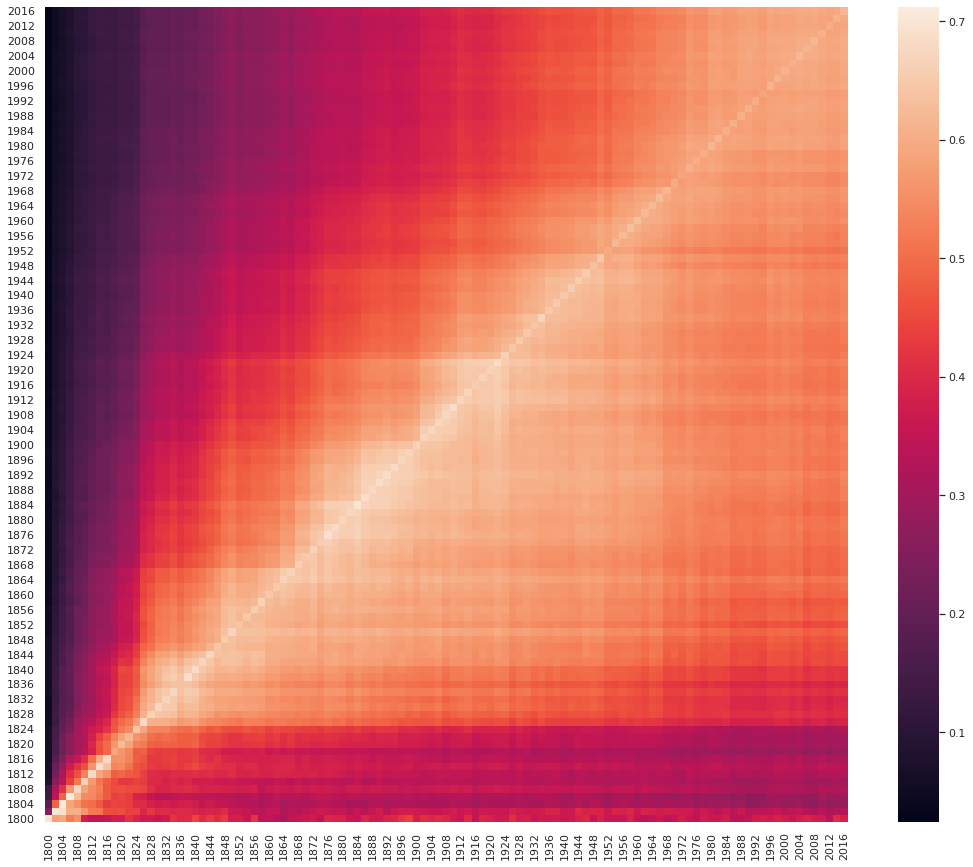

In [23]:
# Set some values lower, so that the rest of the matrix can be better observed
m = sim_all_asymm.copy()
m[0,0] = 0.7
m[1,1] = 0.7

plotHistory(m,15,3)

In [31]:
# Save matrices (don't wanna repeat these calcs)
np.save('./Genetic1D/History_all_symm.npy',sim_all_symm)
np.save('./Genetic1D/History_all_asymm.npy',sim_all_asymm)

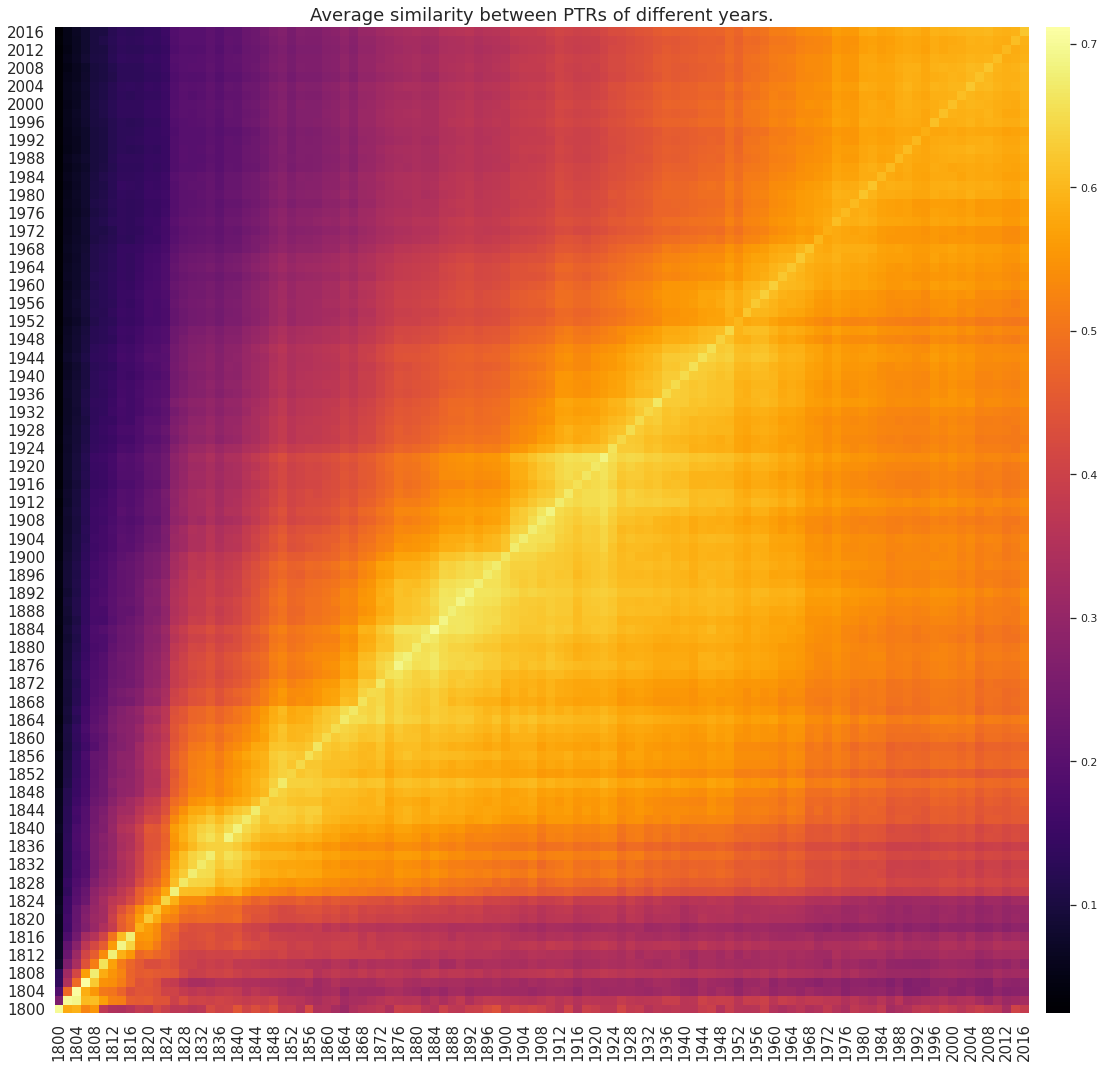

In [71]:
def plotHistory(matrix,sz=15,pad=4):
    fig,ax = plt.subplots(1,2,figsize=(sz+pad,sz),
                          gridspec_kw={'hspace':0.0,
                                       'width_ratios':[40,1]})
    axi, cbar = ax
    
    sns.heatmap(matrix,ax=axi,cmap='inferno',cbar_ax=cbar)

    labels = [i for j,i in enumerate(Indivs_yr.keys()) if j%2==0]
    locs = (np.array(labels) - 1800)/2  + 0.5
    
    axi.set_title('Average similarity between PTRs of different years.',fontsize=18)
    axi.set_xticks(locs)
    axi.set_yticks(locs)
    axi.set_xticklabels(labels,rotation=90,fontsize=15)
    axi.set_yticklabels(labels,rotation=0,fontsize=15)
    axi.invert_yaxis()
    plt.tight_layout()
    plt.savefig('../Data/Results/history_mat.png',bbox_inches='tight',dpi=400)
    
m1 = np.load('./Genetic1D/History_all_asymm.npy')
m1[0,0] = 0.7
m1[1,1] = 0.7
plotHistory(m1,pad=0.5)

---

## Other side-results:

---

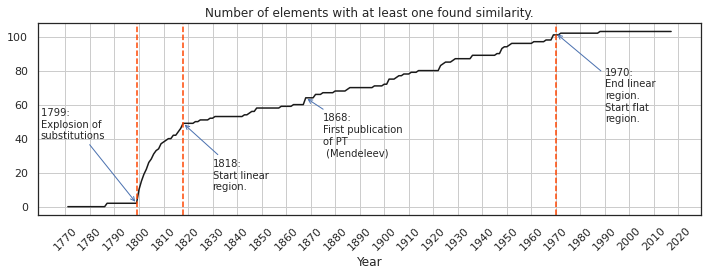

In [101]:
# Plot number of elements appearing in HND table each year
elem_count = (simMat_yr.sum(axis=1)>0).sum(axis=1)
plot_count_elems_w_matches(min_yr,2017,elem_count)

The interpretation of the numbers on y-axis is as follows: 

`An element Y is counted (for a given year), iff there exists at least one compound RXn, such that X = Y and at least one any other element. That is, if Y is related to any other element by a formula substitution relationship.`

This is an interesting plot, as it shows how relationships between elements, within the chemical space, evolve with time. It is quite interesting to see how compounds were mostly unrelated until 1800, but this year the number of related, or relatable elements, explodes and this explotion lasts until about 1818, where a seemingly constant growth is established.

Some questions arise, the most important being:

- What exactly happened in 1800? 
- Why are the numbers so low before this year?
- How can this linear regime be interpreted/explained?

Take into account that, to 1800, about 32 elements were known to humanity, [as shown here](https://environmentalchemistry.com/yogi/periodic/year.html). How come only 2 elements are related through a substitution relationship?.

### Let's explore the necessary conditions leading to the change we observe around 1800, which may help answer our first and second question.

To be simplistic, let's assume the number of related elements (F) is 0 before 1800, that is F(1799) = 0.
This means that, although some compounds are known, every one of these is a singular compound in terms of replaceability of elements. If we conceive each compound as the set of substitution formulas it gives rise to, then the set of compounds would be a non-overlapping partitioning of the space of substitution formulas, in this particular scenario.

With this in mind, whatever happened in 1800 can be abstracted as an introduction of a new set of compounds, one rich enough to build "bridges" between the aforementioned partitions. For the effects of this discussion, we may define "bridge" as follows.

- A new compound C -abstracted as a set of substitution formulas- is a $\textbf{bridge}$ between two other compounds A and B, if A $\cap$ B = $\varnothing$, while both C $\cap$ A and C $\cap$ B are not null.

This observation sets a $\textit{strict}$ lower bound for the possible generation of the periodic system: `No periodic system could have been created before 1800, even though 32 elements were known to that year.` There is, however, evidence that the PS could have been robustly postulated by the 1840s.

`If true, this would be a really interesting conclusion.` However, there is still the possibility that all of these results are influenced and biased by the way the data were curated, before and after I got my hands on it. 

---

### To answer our third question, let us explore a bit further the linear behaviour of this plot between the pertinent years.

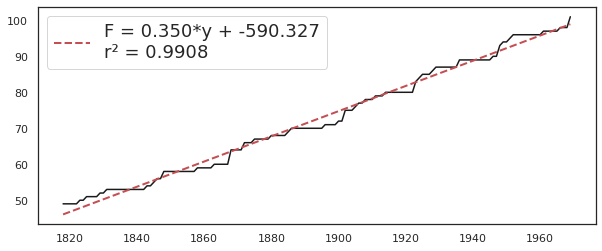

In [104]:
init = 1818
end = 1970

years = np.arange(init,end,1)
ec_subsamp = elem_count[init-min_yr:end-min_yr] # subsample of elem_count

# Fit linear model
from scipy.stats import linregress
lm = linregress(years,ec_subsamp) # Linear model
lin_pred = lm.slope*years + lm.intercept

fig, ax = plt.subplots(figsize=(10,4))
# Plot data
sns.lineplot(x=years,y=ec_subsamp,ax=ax,color='k')
# Plot linear model
label = f'F = {lm.slope:.3f}*y + {lm.intercept:.3f}\nr² = {lm.rvalue**2:.4f}'
sns.lineplot(x=years,y=lin_pred,ax=ax,color='r',
             label = label,linestyle='--',linewidth=2)
plt.legend(fontsize=18)
plt.show()

What we really care about here is the slope, which is about 0.35. This means that, very approximately, `about every three years, one element is brought into consideration for the construction of the Periodic System`, and for the results we just got, this has been a constant for nearly 152 years!.

Now, such a linear behaviour stopped after 1970, probably due to the fact that newer elements were produced synthetically and couldn't be produced in sufficient quantities to be able to form compounds, leaving nearly 16 of these elements out of consideration and as a consquence, stopping the linear increase we see.

---

# Calculate mean(HND) from SMs.

### To calculate a mean, we sum, and then divide by the number of elements.

# sum(HND):

Let's first calculate HND for a single element, H.

Each other element x contributes a given distance, a specific number of times. This distance D(H,X) is the difference in PT groups, which has to be counted N(H,X) times, N(H,X) being the number of times both H and X appear in the same table.

Thus, each element contributes a total N(H,X)*D(H,X) to the sum, which results in the sum:

<br>
<font color='red' >
    $$
    sum(HND(H)) = N(H,H)*D(H,H) + N(H,He)*D(H,He) + N(H,Li)*D(H,Li) + ...
    $$
</font>

Where a term for the pair (H,H) was added as $D(H,H) = 0$, by definition.

<br>
<font color='red' >
    $$
    \begin{align*}
    sum(HND(H)) &= \sum_{X} N(H,X)*D(H,X)\\
           &= \sum_{X} N(H,X)*D(X,H)
    \end{align*}
    $$
</font>

Due to the fact that both matrices are symetric.

---

#### Definitions:

1. Matrix D, where $D_{ij} = D(i,j)$ for elements i and j. 

2. Matrix N. $N_{ij} = N(i,j)$ for elements i and j. 

The above equation is realized as an inner product between the rows of D and N, correspondent to element H.

And, extending the argument to the complete set of elements, we compute the diagonal of the matrix product between N and D:

<br>
<font color='red' >
$$
sum(HND) = Diag(N*D)
$$
</font>

Which is a vector containing sum(HND(X)) for each element X.

# mean(HND):

Renamed as mHND for ease of write and read.

For that, we need to rescale Diag(N*D) using the total number of neighbors of each element.

Number of neighbors of H is equal to the sum of N(H), minus N(H,H); which generalizes as sum(N,axis=0) - Diag(N)

We end up with the following:

<br>
<font color='red' >
$$
mHND = \frac{Diag(N*D)}{sum(N,axis=0) - Diag(N) }
$$
</font>

# Calculation of D.

A vector `g` can be written, such that g(X) = group(X), representing the horizontal position of element X within a given PT (group). 

With this, we could repeat the vector to build a square matrix G, which then can be used to calculate D as follows:

<br>
<font color='red' >
$$
D = |G - G^T|
$$
</font>

Numpy broadcasting rules allow to do this without the repeating step being explicitly made. 

As such, we'd rather calculate 

<font color='red' >
$$
D = |g - g^T|
$$
</font>

The equation is then written in terms of the most fundamental variable here (g), as follows:

<br>
<font color='#8120b1' size=5 >
$$
mHND = \frac{Diag(N*|g - g^T|)}{sum(N,axis=0) - Diag(N) }
$$
</font>

<br>
<font color='#3b8167' size=5 >
Note that N is already calculated and varies yearly, while D is a constant for a given PT, so this makes computation of mHND extremely efficient.
</font>


## Note: If we're looking forward to optimize mHND, that would be only an optimization with respect to element positions in PT, whose information is all encoded in matrix D.
<br>
<font color='green' size=5>
    Which might indicate that this problem can be solved mathematically! I don't yet know how though :c
</font>

<br>
<br>
<font color='red' size=4>
    Important: The original implementation of mHND didn't consider the term -Diag(N), so the results are reproduced if the following equation is used instead of the above.
</font>


$$
mHND = \frac{Diag(N*|g - g^T|)}{sum(N,axis=0)}
$$

---

### Computational note:

Further efficiency can be achieved if the composition of operations `Diag(N*D)` is replaced in numpy with the single operation `np.einsum('ij,ji->i', N, D)`, which directly computes only the diagonal of the matrix product, instead of computing every element of such product, and then extracting the diagonal.

---

### In strict mathemathical terms, mHND for an element is calculated with the following expression:

$$
mHND_{i} = \frac{\sum_k N_{ik} | g_i - g_k |}{\sum_k N_{ik} - N_{ii}}
$$

### If sum of this quantity is used to score a PT, then we get the following:

$$
S = \sum_i \frac{\sum_k N_{ik} | g_i - g_k |}{\sum_k N_{ik} - N_{ii}}
$$

# Which is the quantity to be optimized


---


### Calculating gradients of S with respect to $g_i$ is now trivial.

$$
\frac{\partial S}{\partial g_j} = \sum_i \frac{ sign( g_i - g_j ) N_{ij} }{\sum_k N_{ik} - N_{ii}}
\\
As \\
\frac{\partial g_{k \neq j}}{\partial g_j} = 0
$$



In [52]:
# We regard this array as fixed, so don't count indexing in computation
N = simMat_yr[2015-min_yr]

In [53]:
%%timeit
g = np.array([TP[e][1] for e in elemList_AO]).reshape(1,-1)
D = np.abs(g - g.T)
hnd = np.einsum('ij,ji->i', N, D)/(N.sum(axis=0) - np.diag(N))

86.5 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [54]:
g = np.array([TP[e][1] for e in elemList_AO]).reshape(1,-1)
D = np.abs(g - g.T)
hnd = np.einsum('ij,ji->i', N, D)/(N.sum(axis=0) - np.diag(N))

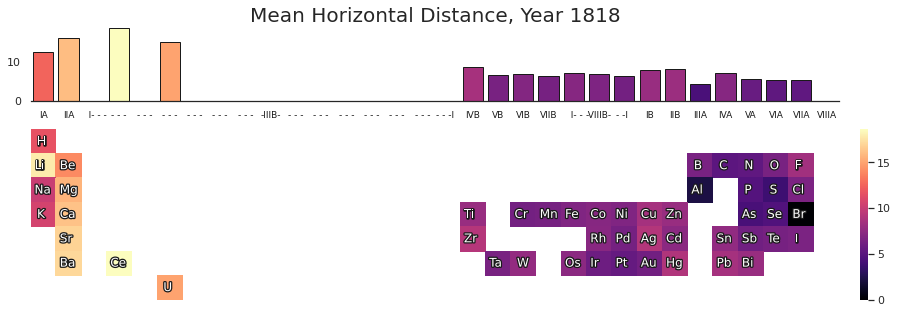

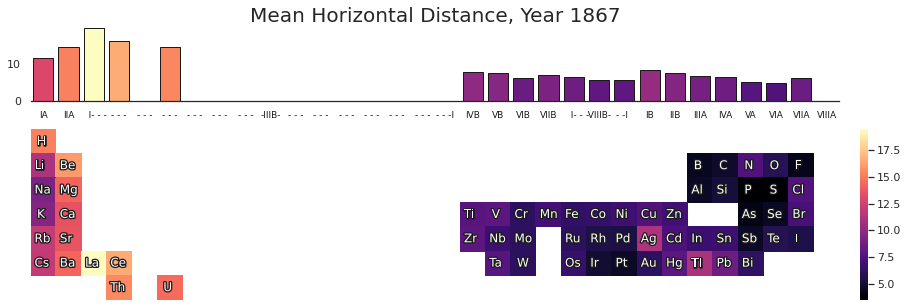

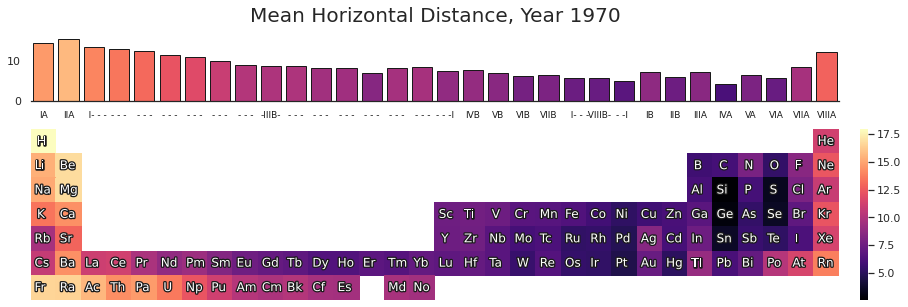

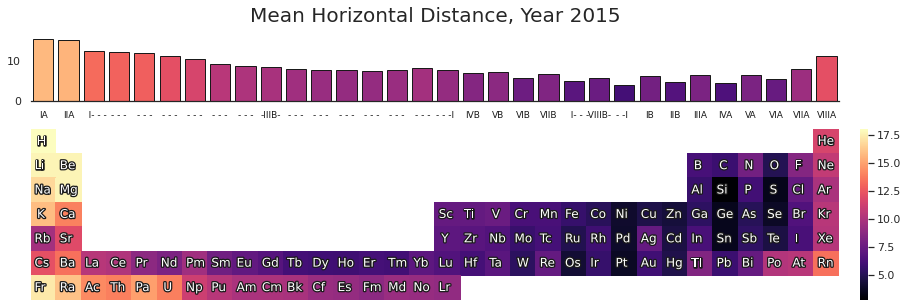

In [55]:
from HND import *

grid_kws = {'width_ratios': (0.99, 0.01), 
            'height_ratios':(0.3,0.7),
            'wspace': 0.05,'hspace':0.23}

dates = [1818,1867,1970,2015]

for d in dates:
    N = simMat_yr[d-min_yr]
    with np.errstate(invalid='ignore',divide='ignore'):
        hnd = np.diag(N@D)/(N.sum(axis=0))# - np.diag(N))
    
    dt = np.zeros((7,32))*np.nan
    for i,e in enumerate(elemList_AO):
        y,x = TP[e]
        dt[y,x] = hnd[i]

    min_scale = np.nanmin(dt)
    max_scale = np.nanmax(dt)

    fig, ax = plt.subplots(2, 2, gridspec_kw = grid_kws, figsize = (15, 5))

    makeTPPlot(dt,title=f"Mean Horizontal Distance, Year {d}",PT=TP,fs=10,ax=ax,
               min_scale=min_scale,max_scale=max_scale)
    plt.show()

# 1818-1867
We see that, for 1818, HND was overall high, with most elements showing an HND above 8, with no clear patterns throughout the table. Interestingly enough, as we move towards 1867, the values drop for most of the table, and now we start getting some patterns, such as lower HNDs to the right of the table.

This might indicate something about how rich was the chemical space at each time. For instance, these results may indicate that, by 1818, the CS wasn't rich enough so as to allow the production of the periodic system (at least the one we have now), while somewhere in between this year and 1868, the CS became rich enough to allow Mendeleev's formulation.

# 1867-1970
In general we observe an interesting evolution of some groups, and some "color gradients" horizontally. Particularly, we see that groups IVA and VIA somehow "survived" the evolution of the CS, and seem to be well preserved throughout history, which can be seen as the values of HND are low for most of these two groups, so we might expect these groups to have strong inner similarity relationships.

Furthermore, actninides and lanthanides show an pattern of decreasing HND when reading from left to right. This might be due to the fact that this group's elements show rather horizontal similarities.

# 1970-2017
Some more groups are further reinforced. Here we clearly see vertical patterns of low HNDs for groups IVA, VIA, as in 1970, showing that these groups further persevere throughout history, while other new ones such as Ni-Pd-Pt appear after nearly 50 years of evolution.

#### In general, we see that group IA and IIA elements show the higher HNDs, regardless of the moment in history, but this is particularly exhacerbated starting from 1970.

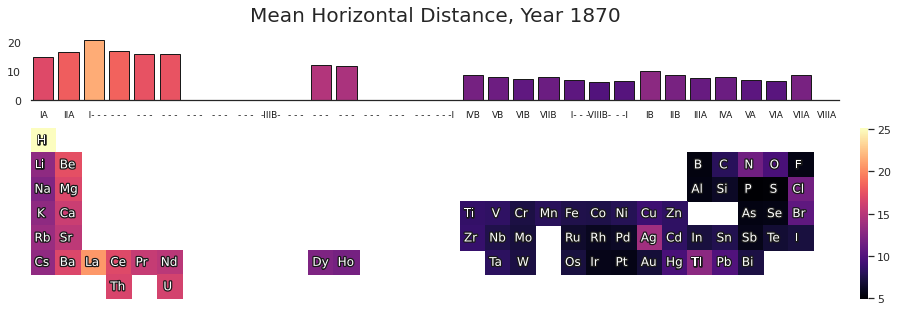

646.7829047956154


In [56]:
d = 1870

N = simMat_yr[d-min_yr]
with np.errstate(invalid='ignore',divide='ignore'):
    hnd = np.diag(N@D)/(N.sum(axis=0) - np.diag(N))

dt = np.zeros((7,32))*np.nan
for i,e in enumerate(elemList_AO):
    y,x = TP[e]
    dt[y,x] = hnd[i]

min_scale = np.nanmin(dt)
max_scale = np.nanmax(dt)

fig, ax = plt.subplots(2, 2, gridspec_kw = grid_kws, figsize = (15, 5))

makeTPPlot(dt,title=f"Mean Horizontal Distance, Year {d}",PT=TP,fs=10,ax=ax,
           min_scale=min_scale,max_scale=max_scale)
#,save='/home/andres/Schreibtisch/GR/work/inf/mHND_1868.png')
plt.show()

print(np.nansum(hnd))